# Label Confusion Evaluation

In [4]:
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import usgoc.datasets.unsafe_go as dataset
import usgoc.models.gnn as gnn
import usgoc.metrics.multi as mm
import usgoc.utils as utils

## Load CFG dataset

In [5]:
split_i = 0 # the evaluated split number (between 0-9)

with utils.cache_env(use_cache=True):
  ds = dataset.load_dataset()
  splits = dataset.get_split_idxs(ds)
  dims, train_ds, val_ds, test_ds = dataset.wl1_tf_datasets(
    ds, splits, split_i, batch_size_limit=200)
  train_ds = train_ds.cache()
  val_ds = val_ds.cache()

## Train Multirelational GCN Model

In [6]:
# No hyperparameter tuning yet (i.e. val_ds has no influence on training):
m = gnn.RGCN(
  node_label_count=dims["node_label_count"],
  conv_layer_units=[256] * 5, fc_layer_units=[128] * 2,
  conv_activation="relu",
  fc_activation="relu",
  out_activation=None,
  pooling="sum", learning_rate=0.001)

m.fit(train_ds, validation_data=val_ds, verbose=2, epochs=500)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/500
6/6 - 6s - loss: 4.5796 - label1_loss: 2.3128 - label2_loss: 2.2668 - label1_accuracy: 0.2416 - label2_accuracy: 0.2910 - accuracy: 0.1455 - val_loss: 4.3991 - val_label1_loss: 2.1989 - val_label2_loss: 2.2002 - val_label1_accuracy: 0.3651 - val_label2_accuracy: 0.4206 - val_accuracy: 0.2857
Epoch 2/500
6/6 - 0s - loss: 4.1672 - label1_loss: 2.1800 - label2_loss: 1.9872 - label1_accuracy: 0.3580 - label2_accuracy: 0.4277 - accuracy: 0.2866 - val_loss: 4.1334 - val_label1_loss: 2.0400 - val_label2_loss: 2.0934 - val_label1_accuracy: 0.3492 - val_label2_accuracy: 0.4206 - val_accuracy: 0.2857
Epoch 3/500
6/6 - 0s - loss: 3.8762 - label1_loss: 2.0604 - label2_loss: 1.8158 - label1_accuracy: 0.3598 - label2_accuracy: 0.5044 - accuracy: 0.3060 - val_loss: 3.7195 - val_label1_loss: 1.8862 - val_label2_loss: 1.8333 - val_label1_accuracy: 0.3730 

In [20]:
train_results = m.evaluate(train_ds, return_dict=True)
val_results = m.evaluate(val_ds, return_dict=True)
test_results = m.evaluate(test_ds, return_dict=True)
print("Train:", train_results)
print("Val:", val_results)
print("Test:", test_results)

1/1 [==============================] - 0s 93ms/step - loss: 9.1474 - label1_loss: 6.6175 - label2_loss: 2.5299 - label1_accuracy: 0.7786 - label2_accuracy: 0.8286 - accuracy: 0.7143
Train: {'loss': 0.1420084685087204, 'label1_loss': 0.0755557119846344, 'label2_loss': 0.0664527490735054, 'label1_accuracy': 0.9576719403266907, 'label2_accuracy': 0.9700176119804382, 'accuracy': 0.9294532537460327}
Val: {'loss': 5.2758870124816895, 'label1_loss': 3.4844484329223633, 'label2_loss': 1.7914386987686157, 'label1_accuracy': 0.7777777910232544, 'label2_accuracy': 0.89682537317276, 'accuracy': 0.7222222089767456}
Test: {'loss': 9.147409439086914, 'label1_loss': 6.61748743057251, 'label2_loss': 2.5299224853515625, 'label1_accuracy': 0.7785714268684387, 'label2_accuracy': 0.8285714387893677, 'accuracy': 0.7142857313156128}


## Compute Confusion Matrices

In [32]:
labels1, labels2 = dataset.create_target_label_dims(ds)
labels1 = labels1.keys()
labels2 = labels2.keys()
train_slice, val_slice, test_slice = dataset.get_dataset_slices(ds, splits, split_i)

train_l1_targets, train_l2_targets = train_slice[1]
test_l1_targets, test_l2_targets = test_slice[1]

train_l1_preds, train_l2_preds = m.predict(train_ds)
test_l1_preds, test_l2_preds = m.predict(test_ds)

train_l1_conf = mm.sparse_multi_confusion_matrix(tf.constant(train_l1_targets), train_l1_preds).numpy()
train_l2_conf = mm.sparse_multi_confusion_matrix(tf.constant(train_l2_targets), train_l2_preds).numpy()
test_l1_conf = mm.sparse_multi_confusion_matrix(tf.constant(test_l1_targets), test_l1_preds).numpy()
test_l2_conf = mm.sparse_multi_confusion_matrix(tf.constant(test_l2_targets), test_l2_preds).numpy()

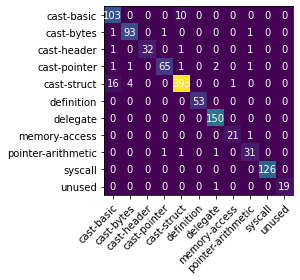

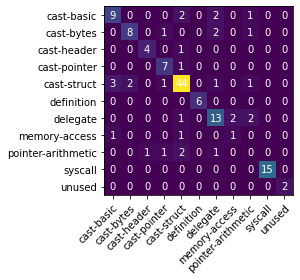

In [33]:
# Confusion matrix for label 1:
utils.draw_confusion_matrix(train_l1_conf, labels1)
utils.draw_confusion_matrix(test_l1_conf, labels1)

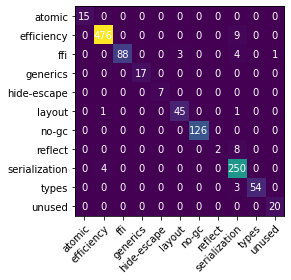

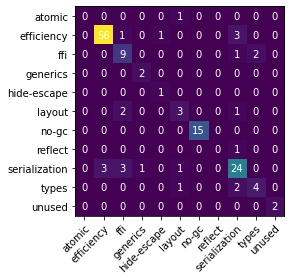

In [34]:
# Confusion matrix for label2:
utils.draw_confusion_matrix(train_l2_conf, labels2)
utils.draw_confusion_matrix(test_l2_conf, labels2)

In [48]:
# Label 1 test accuracy improvement if the cast-* labels were merged:
train_acc1 = train_results["label1_accuracy"]
test_acc1 = test_results["label1_accuracy"]
train_size = np.sum(train_l1_conf)
test_size = np.sum(test_l1_conf)
train_cast_slice = train_l1_conf[:5,:5]
test_cast_slice = test_l1_conf[:5,:5]
train_cast_size = np.sum(train_l1_conf[:5,:5])
test_cast_size = np.sum(test_l1_conf[:5,:5])

train_acc1_diff = train_cast_size - np.sum(np.diag(train_cast_slice))
test_acc1_diff = test_cast_size - np.sum(np.diag(test_cast_slice))

print(f"No. of confusions within cast labels (in train split): {train_acc1_diff}/{train_cast_size}/{train_size}")
print("Train label1 accuracy before merging:", train_acc1)
print("Train label1 accuracy after merging:", train_acc1 + train_acc1_diff / train_size)
print("---")
print(f"No. of confusions within cast labels (in test split): {test_acc1_diff}/{test_cast_size}/{test_size}")
print("Test label1 accuracy before merging:", test_acc1)
print("Test label1 accuracy after merging:", test_acc1 + test_acc1_diff / test_size)

No. of confusions within cast labels (in train split): 37/723/1134
Train label1 accuracy before merging: 0.9576719403266907
Train label1 accuracy after merging: 0.9902998062878899
---
No. of confusions within cast labels (in test split): 11/83/140
Test label1 accuracy before merging: 0.7785714268684387
Test label1 accuracy after merging: 0.8571428554398672
